In [182]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from sortedcontainers import SortedKeyList
from pandas_ml_utils import FeaturesAndLabels, Model, KerasModel
from pandas_ml_utils.ml.data.extraction import extract_with_post_processor
from pandas_ml_quant import pd, np, PostProcessedFeaturesAndLabels

# just in case of GPU issues
os.environ["CUDA_VISIBLE_DEVICES"] = ""

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


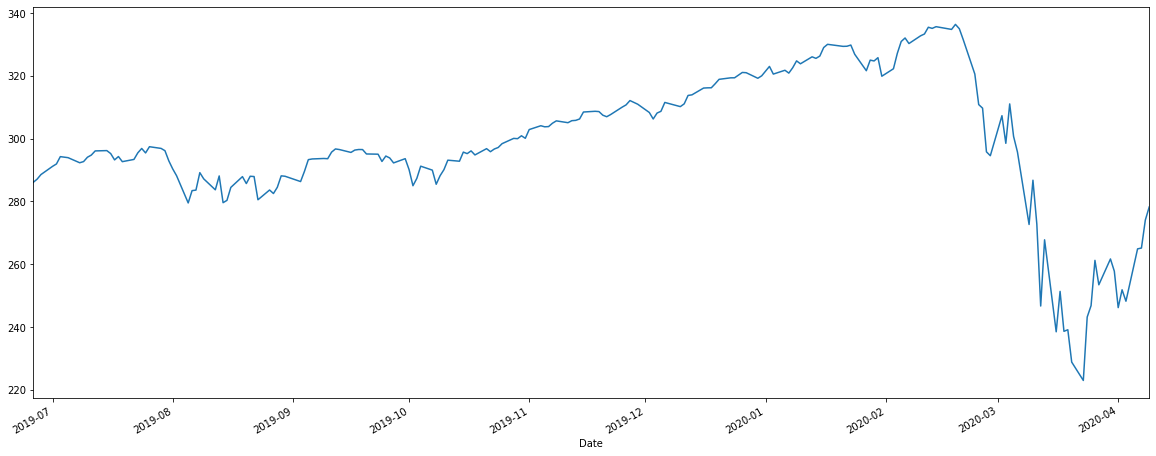

In [152]:
spy = pd.fetch_yahoo("spy")
sspy = spy[-200:]
sspy["Close"].plot(figsize=(20, 8))

*Plan*
1. rnn shape time series using `ta.rnn(3)` or 5 for 5 cande patterns
1. rescale each rnn row to lie between [0, 1]
1. optional: encode candels open, high, low, close as open, upper-shadow, lower-shadow, close
1. encode candles as invertible gaf
1. use gaf endodec 3 day pattern as feature and label
1. build an CNN auto encoder

after training we can:
* drop the decoder and scatter plot the last layer values 
* send any input to the decoder layer and see which neuron "sees" what

In [181]:
ohlc = spy[["Open", "High", "Low", "Close"]]
ohlc3 = ohlc.ta.rnn(3).ta.rescale((0, 1), axis=1)
gaf = ohlc3.ta.gaf(type='invertible', rescale=False) # we might also add voulme?
gaf.tail()

,Open_gaf,High_gaf,Low_gaf,Close_gaf
Date,,,,
2020-04-03,"[[-0.5029027514872939, -0.8163063517907734, -0...","[[-0.06266478501893435, -0.12442391037529105, ...","[[-0.9815947809626827, -0.9893253380367453, -0...","[[-0.8055948739183355, -0.596821315859367, -0...."
2020-04-06,"[[-0.3008376408106549, -0.6125300234156618, -0...","[[1.0, 0.38955823293172653, 0.3609995537706383...","[[-0.9489598037148349, -0.9822763616164565, -0...","[[0.6362655241920652, -0.27561806317004744, -0..."
2020-04-07,"[[0.891483139161239, 0.2006716885032994, -0.04...","[[1.0, 0.7306273062730634, 0.2717208990271721]...","[[-0.12920733245025673, -0.6824144282689389, -...","[[-0.10782805245026472, -0.11985356233320077, ..."
2020-04-08,"[[0.011335311963489192, 0.4172830239295128, -0...","[[1.0, 0.9651455264103476, 0.676607977003234],...","[[-0.246680315745887, -0.26242570032831886, -0...","[[0.7268738938958577, 0.27328175367800506, 0.2..."
2020-04-09,"[[0.21221047084948408, -0.4697474863329052, -0...","[[1.0, 0.6815950920245403, 0.6220858895705509]...","[[-0.1573909443336166, -0.7461993029931188, -0...","[[0.3335548948022118, -0.020086187717652693, -..."


In [203]:
(f, _), l, t, w = spy._.extract(
    FeaturesAndLabels(
        features=[
            lambda df: df[["Open", "High", "Low", "Close"]].ta.rnn(4).ta.rescale((0, 1), axis=1).ta.gaf(type='invertible', rescale=False)
        ],
        labels=[
            lambda df: df[["Open", "High", "Low", "Close"]].ta.rnn(4).ta.rescale((0, 1), axis=1).ta.gaf(type='invertible', rescale=False)
        ]
    )
)

display(f.tail())
display(l.tail())
f._.values.shape

,Open_gaf,High_gaf,Low_gaf,Close_gaf
Date,,,,
2020-04-03,"[[-0.7506940601798722, -0.9100949481626566, -0...","[[-0.5299043851147306, -0.5611479639344016, -0...","[[-0.9907693505779355, -0.9946478166197716, -0...","[[-0.9025012654794428, -0.8002803454083456, -0..."
2020-04-06,"[[-0.2716643241318595, -0.5822077918721711, -0...","[[1.0, 0.4077922077922074, 0.38008658008658025...","[[-0.9316620752984395, -0.9705984311002043, -0...","[[0.646601825303126, -0.24453371944622093, -0...."
2020-04-07,"[[0.8936983808219707, 0.21599888468307513, -0....","[[1.0, 0.7362023653088048, 0.2867936925098554,...","[[-0.11052698831504953, -0.6615573080787953, -...","[[-0.08937078779736785, -0.10126964364738061, ..."
2020-04-08,"[[0.09162553340248847, 0.46935397942574864, -0...","[[1.0, 0.9684860298895378, 0.7076023391812866,...","[[-0.15305606325635285, -0.16816111868957906, ...","[[0.7521822690193554, 0.33700164978694863, 0.3..."
2020-04-09,"[[0.586594362537836, 0.1698663282957224, 0.422...","[[1.0, 0.8428225317989099, 0.8134463961235607,...","[[0.3671027342054715, -0.05377711566903465, -0...","[[0.6541943083886157, 0.45368367099186035, 0.1..."


,Open_gaf,High_gaf,Low_gaf,Close_gaf
Date,,,,
2020-04-03,"[[-0.7506940601798722, -0.9100949481626566, -0...","[[-0.5299043851147306, -0.5611479639344016, -0...","[[-0.9907693505779355, -0.9946478166197716, -0...","[[-0.9025012654794428, -0.8002803454083456, -0..."
2020-04-06,"[[-0.2716643241318595, -0.5822077918721711, -0...","[[1.0, 0.4077922077922074, 0.38008658008658025...","[[-0.9316620752984395, -0.9705984311002043, -0...","[[0.646601825303126, -0.24453371944622093, -0...."
2020-04-07,"[[0.8936983808219707, 0.21599888468307513, -0....","[[1.0, 0.7362023653088048, 0.2867936925098554,...","[[-0.11052698831504953, -0.6615573080787953, -...","[[-0.08937078779736785, -0.10126964364738061, ..."
2020-04-08,"[[0.09162553340248847, 0.46935397942574864, -0...","[[1.0, 0.9684860298895378, 0.7076023391812866,...","[[-0.15305606325635285, -0.16816111868957906, ...","[[0.7521822690193554, 0.33700164978694863, 0.3..."
2020-04-09,"[[0.586594362537836, 0.1698663282957224, 0.422...","[[1.0, 0.8428225317989099, 0.8134463961235607,...","[[0.3671027342054715, -0.05377711566903465, -0...","[[0.6541943083886157, 0.45368367099186035, 0.1..."


(6846, 4, 4, 4)

In [216]:
from keras.layers import Dense, Flatten, Reshape
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras import backend as K 

K.clear_session()


def model():
    m = Sequential([
        Flatten(input_shape=(4,4,4)),
        Dense(8),
        Activation('relu'),
        Dense(4),
        Activation('relu'),
        
        Dense(2),
        
        Dense(4),
        Activation('relu'),
        Dense(8),
        Activation('relu'),
        Dense(64),
        Reshape((4,4,4))
    ])
    
    m.compile(loss='binary_crossentropy', optimizer='adadelta')
    return m
    
    
model().summary()
K.clear_session()


fit = spy.model.fit(
    KerasModel(
        model,
        FeaturesAndLabels(
            features=[
                lambda df: df[["Open", "High", "Low", "Close"]].ta.rnn(4).ta.rescale((0, 1), axis=1).ta.gaf(type='invertible', rescale=False)
            ],
            labels=[
                lambda df: df[["Open", "High", "Low", "Close"]].ta.rnn(4).ta.rescale((0, 1), axis=1).ta.gaf(type='invertible', rescale=False)
            ]
        ),
        output_shape=(4,4,4)
    ),
    epochs=20,
    verbose=1
)

fit

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 520       
_________________________________________________________________
activation_1 (Activation)    (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
_________________________________________________________________
activation_2 (Activation)    (None, 4)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 12        
__________

pass args to fit: {'callbacks': [], 'epochs': 20, 'verbose': 1}
Train on 4107 samples, validate on 2739 samples
Epoch 1/20
4107/4107 [==============================] - 0s 119us/step - loss: -4.7789 - val_loss: -4.9362
Epoch 2/20
4107/4107 [==============================] - 0s 57us/step - loss: -4.9767 - val_loss: -5.0297
Epoch 3/20
4107/4107 [==============================] - 0s 55us/step - loss: -5.0187 - val_loss: -5.1094
Epoch 4/20
4107/4107 [==============================] - 0s 67us/step - loss: -5.1008 - val_loss: -5.1525
Epoch 5/20
4107/4107 [==============================] - 0s 64us/step - loss: -5.1291 - val_loss: -5.1599
Epoch 6/20
4107/4107 [==============================] - 0s 58us/step - loss: -5.2013 - val_loss: -5.2630
Epoch 7/20
4107/4107 [==============================] - 0s 65us/step - loss: -5.2275 - val_loss: -5.2682
Epoch 8/20
4107/4107 [==============================] - 0s 62us/step - loss: -5.2346 - val_loss: -5.2786
Epoch 9/20
4107/4107 [=========================

In [225]:
fit.model.keras_model.get_layer(None, 0).input

<tf.Tensor 'flatten_1_input:0' shape=(?, 4, 4, 4) dtype=float32>

In [204]:
from keras.layers import Dense, Input, LSTM, Lambda, Concatenate, Conv2D, Activation, MaxPooling2D, UpSampling2D
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras import backend as K 

K.clear_session()


def model():
    m = Sequential()
    
    m.add(Conv2D(16, (1,1), input_shape=(4,4,4), data_format='channels_first', padding='same'))
    m.add(Activation('relu'))
    m.add(MaxPooling2D(pool_size=(2,2), padding='same'))

    m.add(Conv2D(2, (2,2), data_format='channels_first', padding='same'))
    m.add(Activation('relu'))
    m.add(MaxPooling2D(pool_size=(2,2), padding='same'))

    # TODO target shape should be 1,1,2

    m.add(Conv2D(2, (2,2), data_format='channels_first', padding='same'))
    m.add(Activation('relu'))
    m.add(UpSampling2D((2,2)))
    
    m.add(Conv2D(16, (1,1), data_format='channels_first', padding='same'))
    m.add(Activation('relu'))
    m.add(UpSampling2D((2,2)))
    
    m.add(Conv2D(4, (1,1), data_format='channels_first', padding='same'))
    m.add(Activation('relu'))

    m.compile(loss='binary_crossentropy', optimizer='adadelta')
    return m



model().summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 4, 4)          80        
_________________________________________________________________
activation_1 (Activation)    (None, 16, 4, 4)          0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 2, 4)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 4)           66        
_________________________________________________________________
activation_2 (Activation)    (None, 2, 2, 4)           0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 4)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 1, 4)           10        
__________

In [207]:
K.clear_session()


fit = spy.model.fit(
    KerasModel(
        model,
        FeaturesAndLabels(
            features=[
                lambda df: df[["Open", "High", "Low", "Close"]].ta.rnn(4).ta.rescale((0, 1), axis=1).ta.gaf(type='invertible', rescale=False)
            ],
            labels=[
                lambda df: df[["Open", "High", "Low", "Close"]].ta.rnn(4).ta.rescale((0, 1), axis=1).ta.gaf(type='invertible', rescale=False)
            ]
        )
    ),
    epoch=20,
    verbose=1
)

fit

pass args to fit: {'callbacks': [], 'verbose': 1}


ValueError: Error when checking target: expected activation_5 to have 4 dimensions, but got array with shape (4107, 64)

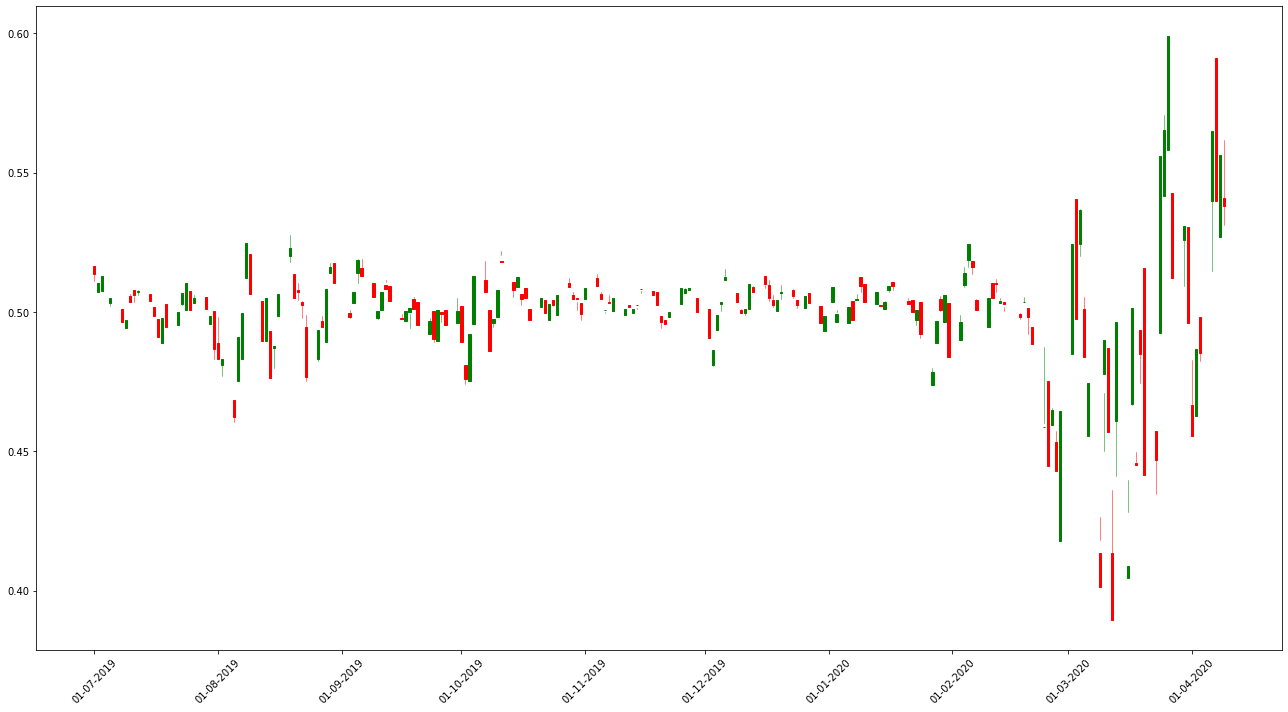

In [169]:

scaled = sspy[["Open", "High", "Low", "Close"]].ta.ma_ratio(period=3, lag=1) + 0.5
tp = scaled.ta.plot(1, 1)
tp.candlestick("Open_sma(3) x 1/", "High_sma(3) x 1/", "Low_sma(3) x 1/", "Close_sma(3) x 1/")

In [173]:
scaled.ta.candles_as_culb("Open_sma(3) x 1/", "High_sma(3) x 1/", "Low_sma(3) x 1/", "Close_sma(3) x 1/", None)

,close,upper,lower,body
Date,,,,
2019-06-26,NaN,NaN,NaN,NaN
2019-06-27,NaN,NaN,NaN,NaN
2019-06-28,NaN,NaN,NaN,NaN
2019-07-01,0.513730,-0.003464,0.005020,-0.005212
2019-07-02,0.510384,-0.004902,-0.001285,0.006468
2019-07-03,0.512770,-0.004027,-0.007547,0.010282
2019-07-05,0.505050,-0.001840,0.001892,0.003682
2019-07-08,0.496375,0.000061,-0.009380,-0.009036
2019-07-09,0.497206,-0.001472,-0.004957,0.005729


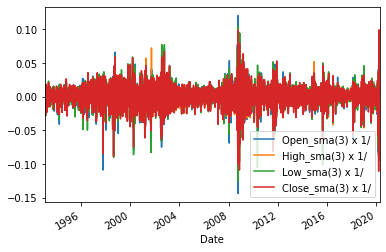

In [170]:
spy[["Open", "High", "Low", "Close"]].ta.ma_ratio(period=3, lag=1).plot()

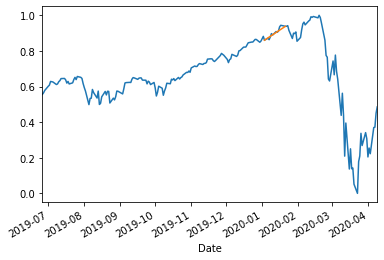

In [41]:
from datetime import datetime

series.plot()

x = [datetime.strptime("2020-01-03 00:00:00", "%Y-%m-%d %H:%M:%S"), datetime.strptime("2020-01-21 00:00:00", "%Y-%m-%d %H:%M:%S")]
y = [0.8604,  0.9383]

plt.plot(x, y)

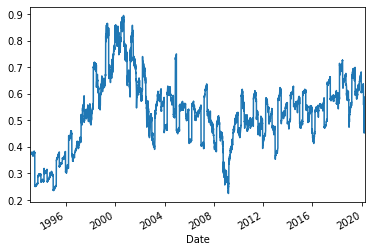

In [49]:
s = pd.fetch_yahoo("SPY")

(s["Close"] / s["Dividends"].replace(to_replace=0, method='ffill') / s["Close"].max()).plot()

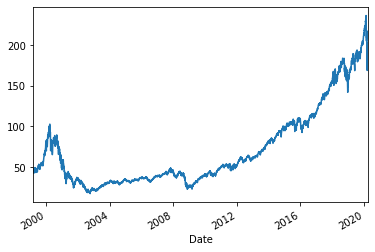

In [2]:
df = pd.fetch_yahoo("QQQ")
df["Close"].plot()


Where:
X : data point
F50 : mean of the latest 200 points
F75 : percentile 75
F25 : Percentile 25
N : normal CDF

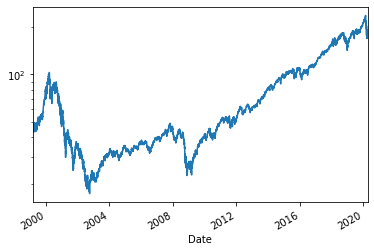

In [3]:
df["Close"].plot()
plt.yscale('log')

  fup = df.rolling(period).apply(lambda x: np.percentile(x, upper_percentile)).rename("fup")

  flo = df.rolling(period).apply(lambda x: np.percentile(x, lower_percentile)).rename("flo")

  return (a < x) & (x < b)

  return (a < x) & (x < b)

  cond2 = (x >= _b) & cond0



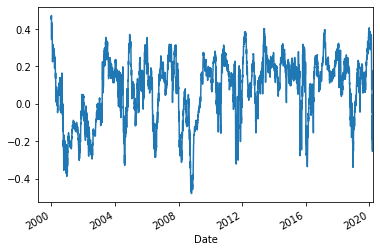

In [4]:
df["Close"].ta.ncdf_compress().plot()

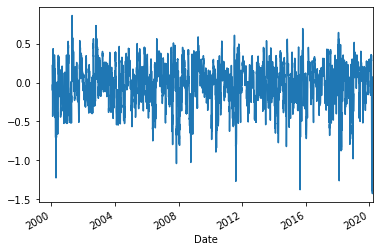

In [13]:
df["Close"].ta.ma_ratio().ta.z_norm().plot()

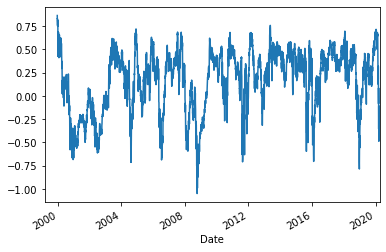

In [11]:
df["Close"].ta.z_norm().plot()

In [ ]:
sad

In [ ]:
#df["Close"].pct_change().plot()
(df["Close"].ta.log_returns() / df["Volume"].ta.ma_ratio(period=60)).plot()
#df["Close"].ta.log_returns().plot()

In [ ]:
b.hist(bins=21)

In [ ]:
df["Close"].pct_change().hist(bins=20)

In [ ]:
(df["TLT", "Close"] / df["SPY", "Close"]).loc["2010-01-01":"2010-07-01"].plot()
pd.fetch_yahoo("^VIX")[df.index[0]:]["Close"].loc["2010-01-01":"2010-07-01"].plot(secondary_y=True)
plt.legend(loc='best')

In [ ]:
df = pd.read_ts_csv("data/SPY.csv")[-200:]
df.ta.adx().plot()

In [ ]:
df.ta.volume_as_time()["Close"].plot()

In [ ]:
df["Close"].plot()

In [ ]:
df = pd.fetch_yahoo("SPY", "GLD", multi_index=True)._["Close"]
weights = df.ta.markowitz(return_period=20)

prices = df.loc[weights.index]
weights.columns = prices.columns
shares_for_one_dollar = weights / prices

portfolios = shares_for_one_dollar.ta.backtest(df, lambda shares: shares * 100)


In [ ]:
from arch import arch_model

df = pd.fetch_yahoo("spy")
returns = 100 * df["Close"].pct_change().dropna()

am = arch_model(returns, vol='Garch', p=1, o=1, q=1, dist='StudentsT')
res = am.fit(update_freq=5)

In [ ]:
fc = res.forecast(horizon=5, start='2020-01-01')
fc.variance[-90:].plot()
hist = returns.rolling(30).std(ddof=1) #* np.sqrt((1 / 30) * 52 * 5)
hist.shift(5)[-90:].plot()

In [ ]:
fc.tail()

In [ ]:
returns = 1000 * df["Close"].pct_change().dropna()
am = arch_model(returns, vol='Garch', p=1, o=1, q=1, dist='StudentsT')

for i in range(200, len(returns)):
    res = am.fit(first_obs=returns.index[i-200], last_obs=returns.index[i], disp='off')


In [ ]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=30)

(f, _), l, t, w = df._.extract(FeaturesAndLabels(
    features=extract_with_post_processor(["Close"], lambda df: df.ta.rnn(range(1, 250))),
    labels=[lambda df: df["Close"].shift(-5)]
))

clf.fit(f.values, l.values)

In [ ]:
#df["Close"].plot()
df[["Close"]].shift(-5).join(pd.Series(clf.predict(f.values), index=f.index, name="forecast")).tail(40).plot()

In [ ]:
pd.fetch_yahoo('fxi')["Close"].plot()

In [ ]:
pd.fetch_yahoo("SPY").ta.tr().plot()

In [ ]:
pd.fetch_yahoo("SPY").ta.tr(relative=False).plot()

In [ ]:
import pandas_ml_quant.analysis.filters as filters
import pandas_ml_quant.analysis.indicators.single_object as simple_indicators
import pandas_ml_quant.analysis.indicators.multi_object as ohlc_indicators


df = pd.read_ts_csv("data/SPY.csv")[-200:]
qp = df.ta.plot(4, 1)
qp.candlestick()
qp.line(df["Close"].ta.sma(period=20))
qp.bar("Volume", panel=1)

for indicator in dir(filters):
    if indicator.startswith("ta_"):
        try:
            x = getattr(df["Close"].q, indicator)()
            qp.line(x, panel=0)
            print(f"{indicator} {x.min()}, {x.max()}")    
        except:
            print(f"failed {indicator}")    

for indicator in dir(simple_indicators):
    if indicator.startswith("ta_"):
        try:
            x = getattr(df["Close"].q, indicator)()
            qp.line(x, panel=2)
            # print(f"{indicator} {x.min()}, {x.max()}")    
        except:
            print(f"failed {indicator}")    

for indicator in dir(ohlc_indicators):
    if indicator.startswith("ta_"):
        try:
            x = getattr(df.q, indicator)()
            qp.line(x, panel=3)
            #print(f"{indicator} {x.min()}, {x.max()}")    
        except:
            print(f"failed {indicator}")    

qp.set_scale(0, 220, 350)
qp.with_symetric_scale(2, 3)

In [ ]:
getattr(df.q, "ta_sma")()

In [ ]:
df = pd.fetch_yahoo("SPY", "^VIX", multi_index=True)
df = df._["Close"].plot()

In [ ]:

import pandas_ml_quant.analysis.indicators as indicators
[indcator for indcator in dir(indicators) if indcator.startswith("ta_")]

In [ ]:
c = df["Close"]
bt = c.ta.sma(20)\
      .ta.cross(c.ta.sma(60))\
      .ta.backtest(c, lambda sig: (sig, 1 if sig > 0 else -1))

bt["net"].plot(figsize=(25, 5))

In [ ]:
c.plot(figsize=(25, 5))
c.ta.sma(20).plot()
c.ta.sma(60).plot()


In [ ]:
c.ta.sma(20)\
      .ta.cross(c.ta.sma(60)).plot(figsize=(25, 5))

In [ ]:
acc = np.repeat([
    [12],
    [0],
    [0],
    [0],
    [0]
  ], 2, axis=1)

acc.shape

In [ ]:
obs = np.array([
    df['Open'].values[-2:],
    df['High'].values[-2:],
    df['Low'].values[-2:],
    df['Close'].values[-2:],
    df['Volume'].values[-2:],
  ])

obs.shape

In [ ]:
np.append(obs, acc[:, -(2):], axis=0).shape

In [ ]:
from lppl_module import lppl_wrapper, abcc_solver_wrapper


df = pd.fetch_yahoo("SPY")
t = df.ta.decimal_year().values

lppl = lppl_wrapper()
#lppl = np.vectorize(lppl)
plt.plot(t, lppl(t, 2099.99, -0.20068926, 2.4125999, 1.76619916, 200, 200, 200))


In [ ]:
import pymc3 as pm
import theano
from lppl_module import lppl_wrapper, abcc_solver_wrapper

data = np.log(df["Close"][-300:-90])

abcc_solver = abcc_solver_wrapper(Sum=pm.math.sum, Cos=pm.math.cos, Sin=pm.math.sin, Stack=pm.math.stack, LinSolver=lambda A, b: pm.math.matrix_dot(pm.math.matrix_dot(pm.math.matrix_inverse(pm.math.matrix_dot(A.T, A)), A.T), b))
lppl = lppl_wrapper(Cos=pm.math.cos, Sin=pm.math.sin, Log=pm.math.log)

prices = data.values
t = data.ta.decimal_year().values
N = len(t)

# define model
with pm.Model() as model:
    # priors
    tc = pm.Exponential('tc', lam=1) + max(t)
    m = pm.HalfCauchy('m', beta=1)
    w = pm.HalfCauchy('w', beta=1)
    sd = pm.HalfCauchy('sd', beta=1)
    
    # link - FIXME slaving does not work .. somehow ... 
    dt = tc - t
    dtPm = dt ** m
    dtln = np.log(dt)
    abcc = abcc_solver(prices, dtPm, dtln, w, N)
    a, b, c1, c2 = abcc[0], abcc[1], abcc[2], abcc[3]
    
    link = lppl(t, tc, m, w, a, b, c1, c2)
    
    # likelihod
    like = pm.Normal('activity', mu=link, sd=sd, observed=prices)

# fit posterioir
with model:
    trace = pm.sample(2000, tune=2000, )


In [ ]:
plt.plot(t, prices)

In [ ]:
import arviz as az

az.plot_trace(trace);

In [ ]:
az.plot_posterior(trace);

In [ ]:
pm.sample_posterior_predictive(trace, samples=500, model=model)

In [ ]:
# fetch china and us index data
df = pd.fetch_yahoo("SPY", "FXI", multi_index=True)

# offset to start of crisis, then look at the most recent 90 days and normalize
close = df._["Close"]
close["Close", "SPY"] = close["Close", "SPY"].shift(-21)
close = close[-70:]
close = close / close.iloc[0]

close.plot(figsize=(16, 9))

In [ ]:
close = df._["Close"].plot()

In [ ]:
df = pd.fetch_yahoo("SPY")
#df["Close"].ta.rescale((0, 1)).ta_plot()
df[-200:].ta.plot()()

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

def f(x):
    return x**2-6*x+9

def data_generator(x,sigma_0,samples):
    return np.random.normal(f(x),sigma_0*x,samples)

sigma_0 = 0.1
x_vals = np.arange(1,5.2,0.2)
x_arr = np.array([])
y_arr = np.array([])
samples = 50
for x in x_vals:
    x_arr = np.append(x_arr, np.full(samples,x))
    y_arr = np.append(y_arr, data_generator(x,sigma_0,samples))
x_arr, y_arr = shuffle(x_arr, y_arr)

In [ ]:
def mdn_cost(mu, sigma, y):
    dist = tf.distributions.Normal(loc=mu, scale=sigma)
    return tf.reduce_mean(-dist.log_prob(y))

epochs = 500
batch_size = 50
learning_rate = 0.0003
display_step = 50
batch_num = int(len(x_arr) / batch_size)

tf.reset_default_graph()
x = tf.placeholder(name='x',shape=(None,1),dtype=tf.float32)
y = tf.placeholder(name='y',shape=(None,1),dtype=tf.float32)

layer = x
for _ in range(3):
    layer = tf.layers.dense(inputs=layer, units=12, activation=tf.nn.tanh)

mu = tf.layers.dense(inputs=layer, units=1)
sigma = tf.layers.dense(inputs=layer, units=1, activation=lambda x: tf.nn.elu(x) + 1)

cost = mdn_cost(mu, sigma, y)

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
x_batches = np.array_split(x_arr, batch_num)
y_batches = np.array_split(y_arr, batch_num)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):
        avg_cost = 0.0
        x_batches, y_batches = shuffle(x_batches, y_batches)
        for i in range(batch_num):
            x_batch = np.expand_dims(x_batches[i],axis=1)
            y_batch = np.expand_dims(y_batches[i],axis=1)
            _, c = sess.run([optimizer,cost], feed_dict={x:x_batch, y:y_batch})
            avg_cost += c/batch_num
        if epoch % display_step == 0:
            print('Epoch {0} | cost = {1:.4f}'.format(epoch,avg_cost))
    #mu_pred, sigma_pred = sess.run([mu,sigma],feed_dict={x:np.expand_dims(x_test,axis=1)})
    print('Final cost: {0:.4f}'.format(avg_cost))


In [ ]:
x_arr.shape

In [ ]:
import librosa
import librosa.display

y = df["Close"].pct_change().dropna()[-400:-100].values
hop_length = 5
n_mels = 64
n_fft = 128
sr = 1

S = librosa.feature.melspectrogram(y, sr=sr, n_fft=n_fft, 
                                   hop_length=hop_length, 
                                   n_mels=n_mels)
S_DB = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(6, 3))
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, 
                         x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB');


In [ ]:
plt = df[-100:].ta.plot(figsize=(10, 6))
plt.candlestick()
plt.line(df[-100:]["Close"].ta.sma(period=20))
plt.bar("Volume", colors=df["Close"][-101:].pct_change().dropna())
plt.line(df[-100:]["Volume"].ta.sma(period=20), panel=1)

In [ ]:
np.linspace(1,2, 10)

In [ ]:
import pywt 

def plot_wavelet(time, signal, scales, 
                 waveletname = 'cmor', 
                 cmap = plt.cm.seismic, 
                 title = 'Wavelet Transform (Power Spectrum) of signal', 
                 ylabel = 'Period (years)', 
                 xlabel = 'Time'):
    
    dt = time[1] - time[0]
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    power = (abs(coefficients)) ** 2
    period = 1. / frequencies
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
    contourlevels = np.log2(levels)
    
    fig, ax = plt.subplots(figsize=(15, 10))
    im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)
    
    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)
    
    yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
    ax.set_yticks(np.log2(yticks))
    ax.set_yticklabels(yticks)
    ax.invert_yaxis()
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], -1)
    
    cbar_ax = fig.add_axes([0.95, 0.5, 0.03, 0.25])
    fig.colorbar(im, cax=cbar_ax, orientation="vertical")
    plt.show()
    
dataset = "http://paos.colorado.edu/research/wavelets/wave_idl/sst_nino3.dat"
df_nino = pd.read_table(dataset)
N = df_nino.shape[0]
t0=1871
dt=0.25
time = np.arange(0, N) * dt + t0
signal = df_nino.values.squeeze()
 
scales = np.arange(1, 128)
plot_wavelet(time, signal, scales)

In [ ]:
#df_spy = pd.fetch_yahoo("spy").pct_change()[-300:]
df_spy = pd.fetch_yahoo("spy")
df_spy["signal"] = df_spy["Close"] / df_spy["Close"].ta.sma() - 1
df_spy = df_spy.dropna()
time = ((df_spy.index.strftime("%j").astype(float) -1) / 366 + df_spy.index.strftime("%Y").astype(float)).values
signal = df_spy["signal"].values.ravel()
 
print(len(df_spy), len(time),len(signal))
scales = np.arange(1, 200)
plot_wavelet(time, signal * 20, scales)
#pywt.cwt(signal, scales, 'cmor', 1/366)

In [ ]:
df_nino.describe()

In [ ]:
from statsmodels.robust import mad

def lets_get_wavy(arr):
    level = 2
    haar = pywt.Wavelet("haar")
    coeffs = pywt.wavedec(arr, haar, level=level, mode="per")
    recomposed_return = pywt.waverec(coeffs, haar)
    sigma = mad(coeffs[-1],center=0)
    uthresh = sigma*np.sqrt(2*np.log(len(arr)))
    coeffs[1:] = ( pywt.threshold( i, value=uthresh, mode="soft" ) for i in coeffs[1:] )
    y = pywt.waverec(coeffs, haar, mode="per" )
    return np.array(coeffs), y

coefficients, frequencies = lets_get_wavy(df_spy["signal"].values)
pd.Series(frequencies).describe()

power = (abs(coefficients)) ** 2
period = 1. / frequencies
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
contourlevels = np.log2(levels)

fig, ax = plt.subplots(figsize=(15, 10))
im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)

ax.set_title(title, fontsize=20)
ax.set_ylabel(ylabel, fontsize=18)
ax.set_xlabel(xlabel, fontsize=18)

yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
ax.set_yticks(np.log2(yticks))
ax.set_yticklabels(yticks)
ax.invert_yaxis()
ylim = ax.get_ylim()
ax.set_ylim(ylim[0], -1)

cbar_ax = fig.add_axes([0.95, 0.5, 0.03, 0.25])
fig.colorbar(im, cax=cbar_ax, orientation="vertical")
plt.show()
